Install Packages

In [1]:
pip install torch numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Imports!!!!!!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import torch
import torch.nn as nn
import torch.optim as optim

Gridworld Environment

In [3]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = [random.randint(0, self.size - 1),
                          random.randint(0, self.size - 1)]
        return self._get_state()

    def step(self, action):
        # actions: 0=up, 1=down, 2=left, 3=right
        dx = [0, 0, -1, 1]
        dy = [-1, 1, 0, 0]
        x, y = self.agent_pos
        nx = np.clip(x + dx[action], 0, self.size - 1)
        ny = np.clip(y + dy[action], 0, self.size - 1)    # Ice Prince's 'Oleku' was ahead of its time, what a banger!
        self.agent_pos = [nx, ny]
        return self._get_state()

    def _get_state(self):
        return np.array(self.agent_pos, dtype=np.float32) / (self.size - 1)

Random Network Distillation

In [4]:
class RNDModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.target = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        self.predictor = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        for param in self.target.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.predictor(x), self.target(x)

Actor and Critic Networks

In [5]:
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim):      # I'm hungry... rice? okay.
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

Curiosity Driven Actor Critic Agent - OwenV2 - [Actor Critic](https://en.wikipedia.org/wiki/Actor-critic_algorithm)

In [6]:
class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, grid_size, penalty_weight=0.01, lr=1e-3):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        self.rnd = RNDModel(state_dim)

        self.actor_optim = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=lr)
        self.rnd_optim = optim.Adam(self.rnd.predictor.parameters(), lr=lr)

        self.visits = defaultdict(int)
        self.grid_size = grid_size
        self.penalty_weight = penalty_weight
        self.memory = []

    def get_state_key(self, state):
        return tuple((state * (self.grid_size - 1)).astype(int))

    def compute_intrinsic_reward(self, state):
        key = self.get_state_key(state)
        self.visits[key] += 1

        s = torch.tensor([state], dtype=torch.float32)    # replaces REINFORCE with more stable updates
        pred, target = self.rnd(s)
        novelty = (pred - target).pow(2).mean().item()
        penalty = self.penalty_weight * self.visits[key]
        return novelty - penalty

    def select_action(self, state):
        s = torch.tensor([state], dtype=torch.float32)
        probs = self.actor(s)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return action.item(), log_prob, entropy

    def store_transition(self, state, log_prob, reward, entropy, next_state):     # In other words - A fancy version of Owen!
        self.memory.append((state, log_prob, reward, entropy, next_state))

    def train_rnd(self, state):
        s = torch.tensor([state], dtype=torch.float32)
        pred, target = self.rnd(s)
        loss = (pred - target).pow(2).mean()
        self.rnd_optim.zero_grad()
        loss.backward()
        self.rnd_optim.step()

    def train(self, gamma=0.99):
        if not self.memory:
            return

        states, log_probs, rewards, entropies, next_states = zip(*self.memory)

        states = torch.tensor(states, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        log_probs = torch.stack(log_probs)
        entropies = torch.stack(entropies)

        values = self.critic(states)
        next_values = self.critic(next_states).detach()
        targets = rewards + gamma * next_values
        advantages = targets - values

        critic_loss = advantages.pow(2).mean()
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        actor_loss = -(log_probs * advantages.detach()).mean() - 0.001 * entropies.mean()
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        self.memory.clear()

Visualization Functions

In [7]:
def render(env, agent, step):
    grid = np.zeros((env.size, env.size))
    for (x, y), count in agent.visits.items():
        if 0 <= y < env.size and 0 <= x < env.size:
            grid[y, x] = count
    grid = np.log1p(grid)
    ax, ay = agent.get_state_key(env._get_state())
    grid[ay, ax] = -1
    plt.figure(figsize=(4, 4))
    plt.title(f"Step {step}")
    plt.imshow(grid, cmap="viridis", origin="upper")
    plt.colorbar(label="log(visits)")
    plt.scatter(ax, ay, c="red", s=100, label="Agent")
    plt.legend()
    plt.show()


def plot_metrics(rewards, entropies, visits):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.title("Intrinsic Reward")

    plt.subplot(1, 3, 2)
    plt.plot(entropies)
    plt.title("Policy Entropy")

    plt.subplot(1, 3, 3)
    plt.plot(visits)
    plt.title("Unique States Visited")
    plt.tight_layout()
    plt.show()

Training Loop!!!!

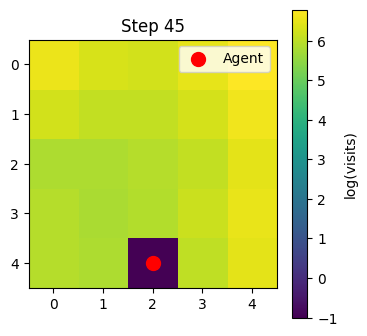

Episode 250, Reward: -204.909, Unique: 25, Entropy: 1.380


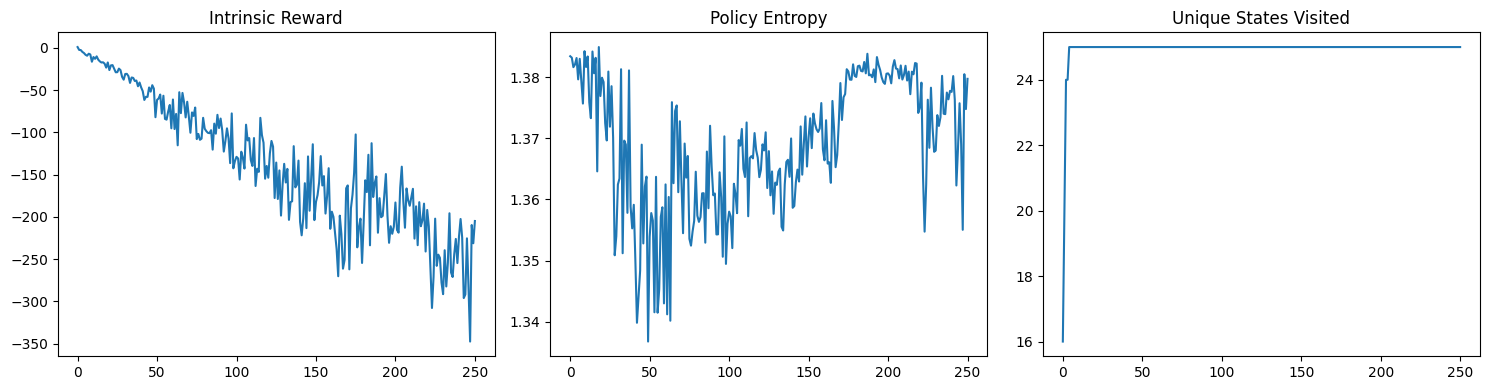

Episode 260, Reward: -275.557, Unique: 25, Entropy: 1.377
Episode 270, Reward: -339.949, Unique: 25, Entropy: 1.353
Episode 280, Reward: -346.068, Unique: 25, Entropy: 1.353
Episode 290, Reward: -319.759, Unique: 25, Entropy: 1.361


In [9]:
env = GridWorld(size=5)
agent = ActorCriticAgent(state_dim=2, action_dim=4, grid_size=env.size)

reward_history = []
entropy_history = []
visited_history = []

num_episodes = 300
episode_length = 50

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    total_entropy = 0

    for step in range(episode_length):
        action, log_prob, entropy = agent.select_action(state)
        next_state = env.step(action)

        reward = agent.compute_intrinsic_reward(next_state)
        agent.train_rnd(next_state)
        agent.store_transition(state, log_prob, reward, entropy, next_state)

        state = next_state
        total_reward += reward
        total_entropy += entropy.item()

        if episode % 50 == 0 and step % 5 == 0:
            from IPython.display import clear_output        # Intrinsic Motivation via Random Network Distilation
            clear_output(wait=True)
            render(env, agent, step)

    agent.train()

    reward_history.append(total_reward)
    entropy_history.append(total_entropy / episode_length)    # Learning eefficiently without going in circles!!
    visited_history.append(len(agent.visits))

    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {total_reward:.3f}, Unique: {len(agent.visits)}, Entropy: {total_entropy / episode_length:.3f}")

    if episode % 50 == 0:
        plot_metrics(reward_history, entropy_history, visited_history)